(ex-rec-system)=
# (EX) Recommendation system with alternating least squares algorithm

This document demonstrates how to use the Alternating Least Squares algorithm in designing a recommendation system.  

*Notebook adapted from* https://gist.github.com/jbochi/2e8ddcc5939e70e5368326aa034a144e

In [18]:
# !pip install implicit 
# !pip install pandas-gbq

In [28]:
import os
print(os.path.abspath(os.curdir))

C:\Users\moses\Desktop\git\de300-wi2024\de300-wn2024-notes\examples


In [30]:
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file(
    '../../misc/de300-rec-system-72c831ee85c4.json',
)

In [19]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
import requests

In [40]:
project_id = "de300-rec-system"
github_user = "mosesyhc"

with open('../../misc/de300-github-api-token.txt') as f:
    github_token = f.readlines()[0]  # from https://github.com/settings/tokens

In [41]:
github_auth = requests.auth.HTTPBasicAuth(github_user, github_token)

In [42]:
query = """
WITH stars AS (
     SELECT actor.login AS user, repo.name AS repo, created_at AS timestamp
     FROM githubarchive.month.202312
     WHERE type="WatchEvent"
),
repositories_stars AS (
     SELECT repo, COUNT(*) as c
     FROM stars
     GROUP BY repo
     ORDER BY c DESC
     LIMIT 1000
),
users_stars AS (
    SELECT user, COUNT(*) as c
    FROM  stars
    WHERE repo IN (SELECT repo FROM repositories_stars)
    GROUP BY user
    HAVING c > 10 AND C < 100
    LIMIT 10000
)
SELECT
user, repo, timestamp
FROM stars
WHERE repo IN (SELECT repo FROM repositories_stars)
AND user IN (SELECT user FROM users_stars)
ORDER BY timestamp DESC
"""

data = pd.io.gbq.read_gbq(query, index_col="timestamp", dialect="standard", project_id=project_id, credentials=credentials)

In [43]:
data.head()

,user,repo
timestamp,,
2023-12-31 23:59:40+00:00,halbtuerke,apple/ml-ferret
2023-12-31 23:58:39+00:00,nv0skar,anasfik/flutter-spy
2023-12-31 23:57:56+00:00,RhetTbull,ofek/pyapp
2023-12-31 23:57:28+00:00,alpapaydin,hiyouga/LLaMA-Factory
2023-12-31 23:55:12+00:00,mikestaub,blakeblackshear/frigate


In [64]:
data.user.unique()

['halbtuerke', 'nv0skar', 'RhetTbull', 'alpapaydin', 'mikestaub', ..., 'YuiINGA', 'Ganesh-Gonela', 'youngabrahamamur', 'chopec79', 'MO-W59']
Length: 8896
Categories (8896, object): ['002301', '00APrIL', '01000111011001010110010101101011', '040828jx', ..., 'zzzarius', 'zzzgydi', 'zzzhc', 'zzzhouuu']

In [65]:
data.repo.unique()

['apple/ml-ferret', 'anasfik/flutter-spy', 'ofek/pyapp', 'hiyouga/LLaMA-Factory', 'blakeblackshear/frigate', ..., 'alsyundawy/Parallels', 'sdg-1/consulting-handbook', 'Yidadaa/ChatGPT-Next-Web', 'samuelcolvin/FastUI', 'FuelLabs/fuels-ts']
Length: 993
Categories (993, object): ['01-ai/Yi', '01mf02/jaq', '100xdevs-cohort-2/assignments', '1Panel-dev/1Panel', ..., 'ziglang/zig', 'zijie0/HumanSystemOptimization', 'zulip/zulip', 'zzzgydi/clash-verge']

In [122]:
# map each repo and user to a unique numeric value
data['user'] = data['user'].astype("category")
data['repo'] = data['repo'].astype("category")

# create a sparse matrix of all the users/repos
stars = coo_matrix((np.ones(data.shape[0]),
                   (data['user'].cat.codes.copy(), 
                    data['repo'].cat.codes.copy())))

In [123]:
stars

<8896x993 sparse matrix of type '<class 'numpy.float64'>'
	with 160360 stored elements in COOrdinate format>

In [124]:
import seaborn as sns

In [132]:
repos_stars = stars.sum(0).T.squeeze()

Text(0.5, 1.0, 'Stars received by repositories')

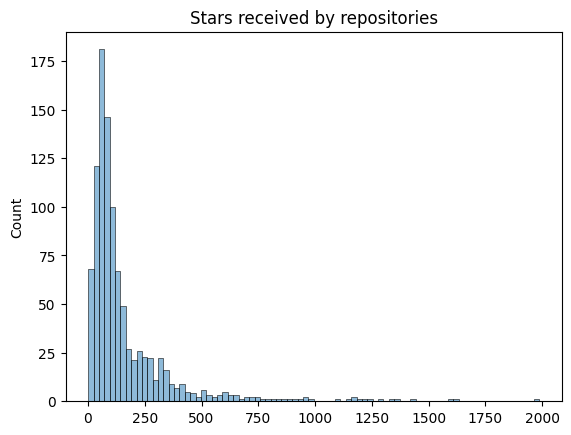

In [135]:
sns.histplot(repos_stars.T, legend=None).set_title('Stars received by repositories')

In [140]:
# retrieve repository names and ids
repos = dict(enumerate(data['repo'].cat.categories))
repo_ids = {r: i for i, r in repos.items()}

In [136]:
# top five repositories in Dec 2023
max_stars_ind = repos_stars.argpartition(-5)[:, -5:]

In [137]:
for i in max_stars_ind.A1:
    print(repos[i])

magic-research/magic-animate
Frooodle/Stirling-PDF
cumulo-autumn/StreamDiffusion
linexjlin/GPTs
lobehub/lobe-chat


In [138]:
# Using the sparse matrix, we may train a low rank model using the ALS algorithm
model = AlternatingLeastSquares(factors=50,
                                regularization=0.01,
                                dtype=np.float64,
                                iterations=50)

In [139]:
confidence = 40
model.fit(confidence * stars)

C:\Users\moses\.venv\de300\Lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007787227630615234 seconds
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

In [141]:
# retrieve top "similar" repositories given an entry
model.similar_items(repo_ids['tensorflow/tensorflow'])

(array([886, 792, 831, 743, 790, 460, 380, 590, 912, 903]),
 array([1.        , 0.67121715, 0.63095779, 0.56379745, 0.55901204,
        0.55380695, 0.50655888, 0.4594498 , 0.44374533, 0.40212771]))

In [142]:
r, s = model.similar_items(repo_ids['tensorflow/tensorflow'])
for k in range(len(r)):
    print(repos[r[k]], s[k])

tensorflow/tensorflow 1.0
pytorch/pytorch 0.671217152423488
scikit-learn/scikit-learn 0.630957789402227
opencv/opencv 0.5637974508120365
python/cpython 0.5590120373055667
github/gitignore 0.5538069504913824
django/django 0.5065588832012623
kubernetes/kubernetes 0.45944979518404866
twbs/bootstrap 0.4437453259482051
torvalds/linux 0.40212770999514447


In [143]:
def user_stars(user):
    repos = []
    url = "https://api.github.com/users/{}/starred".format(user)
    while url:
        resp = requests.get(url, auth=github_auth)
        repos += [r["full_name"] for r in resp.json()]
        url = resp.links["next"]["url"] if "next" in resp.links else None
    return repos

def user_items(u_stars):
    star_ids = [repo_ids[s] for s in u_stars if s in repo_ids]
    data = [confidence for _ in star_ids]
    rows = [0 for _ in star_ids]
    shape = (1, model.item_factors.shape[0])
    return coo_matrix((data, (rows, star_ids)), shape=shape).tocsr()

In [171]:
jbochi = user_items(user_stars("jbochi"))

(1, 993)

In [173]:
def recommend(user_items):
    recs = model.recommend(userid=0, user_items=user_items, recalculate_user=True)
    r, s = recs
        
    for k in range(len(r)):
        print(repos[r[k]], s[k])
    return

In [156]:
recommend(jbochi)

pytorch/pytorch 1.0826900464004112
python/cpython 0.9887264137013962
godotengine/godot 0.9473141561714656
tiangolo/fastapi 0.9387902117490773
astral-sh/ruff 0.926881885357192
jmorganca/ollama 0.9213744145886348
grafana/grafana 0.8618922052213107
tauri-apps/tauri 0.8471787713367438
github/gitignore 0.8440967549120978
openai/whisper 0.8410631315978935
